<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


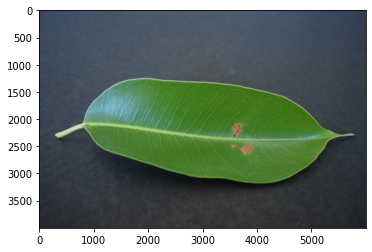

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

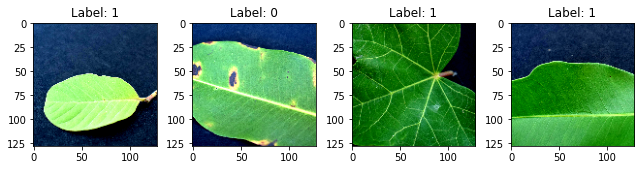

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:10:10] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:12] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2453498358433746 samples/sec                   batch loss = 0.3839687705039978 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.260822363936721 samples/sec                   batch loss = 1.062819242477417 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2667730691001202 samples/sec                   batch loss = 0.5751739740371704 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2656033180905168 samples/sec                   batch loss = 0.4344775080680847 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2675299086214646 samples/sec                   batch loss = 0.6618080735206604 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2718465082891834 samples/sec                   batch loss = 0.9993004202842712 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2732312960275878 samples/sec                   batch loss = 0.39996758103370667 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2692661637379934 samples/sec                   batch loss = 0.40399205684661865 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.2671048646623753 samples/sec                   batch loss = 0.4592513144016266 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2748521347856294 samples/sec                   batch loss = 0.2491733878850937 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2730288964050693 samples/sec                   batch loss = 0.2785623073577881 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2723882116649732 samples/sec                   batch loss = 0.45985692739486694 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.266657631991508 samples/sec                   batch loss = 0.296703577041626 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.2670755815920614 samples/sec                   batch loss = 0.24628384411334991 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.271799458978609 samples/sec                   batch loss = 0.5830694437026978 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2733852401090011 samples/sec                   batch loss = 1.209364414215088 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2684427055276761 samples/sec                   batch loss = 0.39023804664611816 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2698230664322276 samples/sec                   batch loss = 0.8793940544128418 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2749765309913645 samples/sec                   batch loss = 0.3101609945297241 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2676587225879037 samples/sec                   batch loss = 0.23706042766571045 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2698292174729944 samples/sec                   batch loss = 0.37970730662345886 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.2711726278240552 samples/sec                   batch loss = 0.31747326254844666 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.2661226114950106 samples/sec                   batch loss = 0.330140620470047 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.2675895716128267 samples/sec                   batch loss = 0.49692294001579285 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2671506102063186 samples/sec                   batch loss = 0.5949997901916504 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.2606806310340304 samples/sec                   batch loss = 1.1812900304794312 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.263288167930453 samples/sec                   batch loss = 0.5257608890533447 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2640058970612034 samples/sec                   batch loss = 1.2999398708343506 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2615855784209307 samples/sec                   batch loss = 0.5241334438323975 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2636115733490074 samples/sec                   batch loss = 0.7357126474380493 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2641541891098178 samples/sec                   batch loss = 0.4116966426372528 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.2666182332545177 samples/sec                   batch loss = 1.0918351411819458 | accuracy = 0.634375


Epoch[1] Batch[165] Speed: 1.2650237830759083 samples/sec                   batch loss = 0.4866117835044861 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2709152327800854 samples/sec                   batch loss = 0.38929903507232666 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.263416406580344 samples/sec                   batch loss = 0.6503271460533142 | accuracy = 0.6314285714285715


Epoch[1] Batch[180] Speed: 1.265375467825394 samples/sec                   batch loss = 0.7142089009284973 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2662951031156406 samples/sec                   batch loss = 0.18762309849262238 | accuracy = 0.6378378378378379


Epoch[1] Batch[190] Speed: 1.2658972486763784 samples/sec                   batch loss = 0.6717551350593567 | accuracy = 0.6368421052631579


Epoch[1] Batch[195] Speed: 1.2726032460712096 samples/sec                   batch loss = 0.4430483281612396 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.271130251101248 samples/sec                   batch loss = 0.9129061102867126 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.265935647351707 samples/sec                   batch loss = 1.286537766456604 | accuracy = 0.6463414634146342


Epoch[1] Batch[210] Speed: 1.2714569138378309 samples/sec                   batch loss = 0.866615355014801 | accuracy = 0.65


Epoch[1] Batch[215] Speed: 1.2729510452411918 samples/sec                   batch loss = 0.4192013740539551 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2726278619156244 samples/sec                   batch loss = 0.3701828420162201 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.268269436619548 samples/sec                   batch loss = 0.7405416369438171 | accuracy = 0.6544444444444445


Epoch[1] Batch[230] Speed: 1.2741961624685898 samples/sec                   batch loss = 0.5343648791313171 | accuracy = 0.6543478260869565


Epoch[1] Batch[235] Speed: 1.2755139224007606 samples/sec                   batch loss = 0.903587281703949 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.269623670438786 samples/sec                   batch loss = 0.40878307819366455 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.263969329418547 samples/sec                   batch loss = 0.6933022141456604 | accuracy = 0.6602040816326531


Epoch[1] Batch[250] Speed: 1.2628667239993903 samples/sec                   batch loss = 0.8507260084152222 | accuracy = 0.659


Epoch[1] Batch[255] Speed: 1.2588858662110514 samples/sec                   batch loss = 0.32983916997909546 | accuracy = 0.6617647058823529


Epoch[1] Batch[260] Speed: 1.2643224288905976 samples/sec                   batch loss = 0.34470507502555847 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.274075401631968 samples/sec                   batch loss = 0.5866804122924805 | accuracy = 0.6622641509433962


Epoch[1] Batch[270] Speed: 1.2707179960345203 samples/sec                   batch loss = 0.5416568517684937 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.2654386505862412 samples/sec                   batch loss = 0.43332841992378235 | accuracy = 0.6681818181818182


Epoch[1] Batch[280] Speed: 1.2696504771476829 samples/sec                   batch loss = 0.31275609135627747 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.268274805614839 samples/sec                   batch loss = 0.23093833029270172 | accuracy = 0.6701754385964912


Epoch[1] Batch[290] Speed: 1.2637562507184192 samples/sec                   batch loss = 0.5923231244087219 | accuracy = 0.6706896551724137


Epoch[1] Batch[295] Speed: 1.2635971074339707 samples/sec                   batch loss = 0.5672987699508667 | accuracy = 0.6711864406779661


Epoch[1] Batch[300] Speed: 1.2627577953046065 samples/sec                   batch loss = 0.45805835723876953 | accuracy = 0.67


Epoch[1] Batch[305] Speed: 1.2669582714915328 samples/sec                   batch loss = 0.43661069869995117 | accuracy = 0.6704918032786885


Epoch[1] Batch[310] Speed: 1.2656391210450513 samples/sec                   batch loss = 0.8942352533340454 | accuracy = 0.6693548387096774


Epoch[1] Batch[315] Speed: 1.2627273822712106 samples/sec                   batch loss = 0.642041027545929 | accuracy = 0.6714285714285714


Epoch[1] Batch[320] Speed: 1.2673248180354384 samples/sec                   batch loss = 2.0629994869232178 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2683008842385879 samples/sec                   batch loss = 0.7206023335456848 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2613148871131319 samples/sec                   batch loss = 0.607681930065155 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.2670440033271844 samples/sec                   batch loss = 0.4138537347316742 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.263125053266345 samples/sec                   batch loss = 1.933688759803772 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.2687218380008947 samples/sec                   batch loss = 0.4816432595252991 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.2664200335906097 samples/sec                   batch loss = 1.0122171640396118 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2669354052498645 samples/sec                   batch loss = 0.4254654049873352 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2595843207532933 samples/sec                   batch loss = 0.5210782289505005 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.260823974721019 samples/sec                   batch loss = 0.43301257491111755 | accuracy = 0.6719178082191781


Epoch[1] Batch[370] Speed: 1.2659397548106148 samples/sec                   batch loss = 0.9470155835151672 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.26728221884006 samples/sec                   batch loss = 0.7683924436569214 | accuracy = 0.6686666666666666


Epoch[1] Batch[380] Speed: 1.2630284407728065 samples/sec                   batch loss = 0.5044542551040649 | accuracy = 0.6690789473684211


Epoch[1] Batch[385] Speed: 1.267007738110297 samples/sec                   batch loss = 0.5494076609611511 | accuracy = 0.6688311688311688


Epoch[1] Batch[390] Speed: 1.2671712829164217 samples/sec                   batch loss = 0.6301807165145874 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2653652560983493 samples/sec                   batch loss = 0.4817153215408325 | accuracy = 0.6689873417721519


Epoch[1] Batch[400] Speed: 1.2635165040905791 samples/sec                   batch loss = 0.36638814210891724 | accuracy = 0.67


Epoch[1] Batch[405] Speed: 1.2633494300316968 samples/sec                   batch loss = 0.5998197793960571 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2636776258803148 samples/sec                   batch loss = 0.5857434868812561 | accuracy = 0.6695121951219513


Epoch[1] Batch[415] Speed: 1.2604986798255113 samples/sec                   batch loss = 0.4263746738433838 | accuracy = 0.6698795180722892


Epoch[1] Batch[420] Speed: 1.2640462762913267 samples/sec                   batch loss = 0.9685714840888977 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.2652771748655853 samples/sec                   batch loss = 0.38773274421691895 | accuracy = 0.6688235294117647


Epoch[1] Batch[430] Speed: 1.2683110475220816 samples/sec                   batch loss = 0.5831276178359985 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2681774996294235 samples/sec                   batch loss = 0.3893136978149414 | accuracy = 0.6706896551724137


Epoch[1] Batch[440] Speed: 1.266378642263622 samples/sec                   batch loss = 0.9562575221061707 | accuracy = 0.6721590909090909


Epoch[1] Batch[445] Speed: 1.272063288598761 samples/sec                   batch loss = 0.46139317750930786 | accuracy = 0.6730337078651686


Epoch[1] Batch[450] Speed: 1.266726107472591 samples/sec                   batch loss = 0.5411254167556763 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.263175552488195 samples/sec                   batch loss = 0.5502734184265137 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.268158327797133 samples/sec                   batch loss = 0.379304438829422 | accuracy = 0.6755434782608696


Epoch[1] Batch[465] Speed: 1.2675348883031843 samples/sec                   batch loss = 0.5046733617782593 | accuracy = 0.6747311827956989


Epoch[1] Batch[470] Speed: 1.2720726442165453 samples/sec                   batch loss = 0.7099896669387817 | accuracy = 0.673936170212766


Epoch[1] Batch[475] Speed: 1.26922247374683 samples/sec                   batch loss = 0.2299431711435318 | accuracy = 0.6752631578947368


Epoch[1] Batch[480] Speed: 1.2686880669917961 samples/sec                   batch loss = 0.536183774471283 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2668261561914549 samples/sec                   batch loss = 0.508843183517456 | accuracy = 0.6747422680412372


Epoch[1] Batch[490] Speed: 1.2658396550308801 samples/sec                   batch loss = 0.5715230107307434 | accuracy = 0.6755102040816326


Epoch[1] Batch[495] Speed: 1.266275701435401 samples/sec                   batch loss = 0.5314096212387085 | accuracy = 0.6772727272727272


Epoch[1] Batch[500] Speed: 1.26769205566953 samples/sec                   batch loss = 0.4823996126651764 | accuracy = 0.678


Epoch[1] Batch[505] Speed: 1.2669222981947967 samples/sec                   batch loss = 0.28566598892211914 | accuracy = 0.6782178217821783


Epoch[1] Batch[510] Speed: 1.2707199209387134 samples/sec                   batch loss = 0.45949870347976685 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2707285830797515 samples/sec                   batch loss = 0.5216646790504456 | accuracy = 0.6800970873786408


Epoch[1] Batch[520] Speed: 1.2678159206671964 samples/sec                   batch loss = 0.5783323049545288 | accuracy = 0.6798076923076923


Epoch[1] Batch[525] Speed: 1.2628060790041113 samples/sec                   batch loss = 0.5660415291786194 | accuracy = 0.6804761904761905


Epoch[1] Batch[530] Speed: 1.273847199071805 samples/sec                   batch loss = 0.9179696440696716 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.263580833675453 samples/sec                   batch loss = 0.3701753318309784 | accuracy = 0.6799065420560748


Epoch[1] Batch[540] Speed: 1.2623331908771886 samples/sec                   batch loss = 0.576267659664154 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.2661792753037693 samples/sec                   batch loss = 0.7214491367340088 | accuracy = 0.6798165137614679


Epoch[1] Batch[550] Speed: 1.2690708784017763 samples/sec                   batch loss = 0.34710046648979187 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.2676783582427877 samples/sec                   batch loss = 0.4888637959957123 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.267122473434727 samples/sec                   batch loss = 0.27365902066230774 | accuracy = 0.6825892857142857


Epoch[1] Batch[565] Speed: 1.2716984304197687 samples/sec                   batch loss = 0.6870092153549194 | accuracy = 0.684070796460177


Epoch[1] Batch[570] Speed: 1.2702169493835245 samples/sec                   batch loss = 0.4773629605770111 | accuracy = 0.6855263157894737


Epoch[1] Batch[575] Speed: 1.2672709233540211 samples/sec                   batch loss = 1.1626996994018555 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.2713582518969533 samples/sec                   batch loss = 0.4012371003627777 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.2650867399322199 samples/sec                   batch loss = 0.773991048336029 | accuracy = 0.6833333333333333


Epoch[1] Batch[590] Speed: 1.2699396580161704 samples/sec                   batch loss = 0.5504260659217834 | accuracy = 0.6834745762711865


Epoch[1] Batch[595] Speed: 1.2668069295417657 samples/sec                   batch loss = 0.35354241728782654 | accuracy = 0.6840336134453782


Epoch[1] Batch[600] Speed: 1.2662855455633895 samples/sec                   batch loss = 0.5751731395721436 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2625014213022945 samples/sec                   batch loss = 0.8910956382751465 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.2654369325425279 samples/sec                   batch loss = 0.6442830562591553 | accuracy = 0.6819672131147541


Epoch[1] Batch[615] Speed: 1.2660377685966004 samples/sec                   batch loss = 0.8577902913093567 | accuracy = 0.6813008130081301


Epoch[1] Batch[620] Speed: 1.2646823036384947 samples/sec                   batch loss = 0.42036038637161255 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.263430963502625 samples/sec                   batch loss = 0.6218250393867493 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2713467872933946 samples/sec                   batch loss = 0.2812504768371582 | accuracy = 0.6817460317460318


Epoch[1] Batch[635] Speed: 1.2655503334350668 samples/sec                   batch loss = 0.28524577617645264 | accuracy = 0.6834645669291338


Epoch[1] Batch[640] Speed: 1.2721474941132562 samples/sec                   batch loss = 1.015380859375 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.26607359613625 samples/sec                   batch loss = 0.4593348205089569 | accuracy = 0.6852713178294574


Epoch[1] Batch[650] Speed: 1.2672135875089714 samples/sec                   batch loss = 0.8044982552528381 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2624714956162846 samples/sec                   batch loss = 1.2132656574249268 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2671263014934784 samples/sec                   batch loss = 0.32762277126312256 | accuracy = 0.6863636363636364


Epoch[1] Batch[665] Speed: 1.2642999435190674 samples/sec                   batch loss = 0.7240621447563171 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2696791106533387 samples/sec                   batch loss = 0.5412090420722961 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.2700748272396467 samples/sec                   batch loss = 0.6910725235939026 | accuracy = 0.6862962962962963


Epoch[1] Batch[680] Speed: 1.265242346558818 samples/sec                   batch loss = 0.28649938106536865 | accuracy = 0.6867647058823529


Epoch[1] Batch[685] Speed: 1.2688366920733252 samples/sec                   batch loss = 0.4207703471183777 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.2669469817795176 samples/sec                   batch loss = 0.7116501927375793 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.2697703044836233 samples/sec                   batch loss = 0.2766435146331787 | accuracy = 0.6866906474820144


Epoch[1] Batch[700] Speed: 1.261264631368451 samples/sec                   batch loss = 0.8613373041152954 | accuracy = 0.6864285714285714


Epoch[1] Batch[705] Speed: 1.2677928318524219 samples/sec                   batch loss = 0.41671621799468994 | accuracy = 0.6865248226950355


Epoch[1] Batch[710] Speed: 1.2692850809969278 samples/sec                   batch loss = 0.15143369138240814 | accuracy = 0.6873239436619718


Epoch[1] Batch[715] Speed: 1.2703461177255033 samples/sec                   batch loss = 1.690828561782837 | accuracy = 0.6867132867132867


Epoch[1] Batch[720] Speed: 1.2706446615283105 samples/sec                   batch loss = 0.3661041855812073 | accuracy = 0.6871527777777777


Epoch[1] Batch[725] Speed: 1.2699654206273883 samples/sec                   batch loss = 0.30329790711402893 | accuracy = 0.6882758620689655


Epoch[1] Batch[730] Speed: 1.2646382613539529 samples/sec                   batch loss = 0.28091251850128174 | accuracy = 0.6883561643835616


Epoch[1] Batch[735] Speed: 1.2696971754085595 samples/sec                   batch loss = 0.7278695106506348 | accuracy = 0.6877551020408164


Epoch[1] Batch[740] Speed: 1.2713036282873351 samples/sec                   batch loss = 0.35916194319725037 | accuracy = 0.6885135135135135


Epoch[1] Batch[745] Speed: 1.2689778653687565 samples/sec                   batch loss = 0.9502812623977661 | accuracy = 0.6879194630872483


Epoch[1] Batch[750] Speed: 1.2657452051567986 samples/sec                   batch loss = 0.310464084148407 | accuracy = 0.6886666666666666


Epoch[1] Batch[755] Speed: 1.2684384859105493 samples/sec                   batch loss = 0.25128886103630066 | accuracy = 0.6894039735099338


Epoch[1] Batch[760] Speed: 1.2726396392446457 samples/sec                   batch loss = 0.46306905150413513 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.2682393327379633 samples/sec                   batch loss = 0.661819577217102 | accuracy = 0.688562091503268


Epoch[1] Batch[770] Speed: 1.2681999314090837 samples/sec                   batch loss = 0.3608033359050751 | accuracy = 0.6896103896103896


Epoch[1] Batch[775] Speed: 1.2695127084705304 samples/sec                   batch loss = 0.43055790662765503 | accuracy = 0.69


Epoch[1] Batch[780] Speed: 1.2662944340822868 samples/sec                   batch loss = 0.581466019153595 | accuracy = 0.6891025641025641


Epoch[1] Batch[785] Speed: 1.2699584992261657 samples/sec                   batch loss = 0.3394868075847626 | accuracy = 0.689171974522293


[Epoch 1] training: accuracy=0.6894035532994924
[Epoch 1] time cost: 649.2792298793793
[Epoch 1] validation: validation accuracy=0.7266666666666667


Epoch[2] Batch[5] Speed: 1.2656645185022124 samples/sec                   batch loss = 0.5364284515380859 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2630643834583082 samples/sec                   batch loss = 0.4402286112308502 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2707538002070808 samples/sec                   batch loss = 0.7227242588996887 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2609706680969057 samples/sec                   batch loss = 0.4661464989185333 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2578909391031774 samples/sec                   batch loss = 0.46226054430007935 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.268602879934185 samples/sec                   batch loss = 0.15649287402629852 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.264463266484784 samples/sec                   batch loss = 0.4597627818584442 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2634987099329889 samples/sec                   batch loss = 0.30965039134025574 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2592519147670738 samples/sec                   batch loss = 0.3336239457130432 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2681174937265765 samples/sec                   batch loss = 0.34193065762519836 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2620299954121583 samples/sec                   batch loss = 0.5918080806732178 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.268270970613564 samples/sec                   batch loss = 0.4264719784259796 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2580844967171894 samples/sec                   batch loss = 0.5816144347190857 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.262421717617874 samples/sec                   batch loss = 0.9493890404701233 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2621787737320334 samples/sec                   batch loss = 0.16821733117103577 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2633149931503864 samples/sec                   batch loss = 0.828842282295227 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2658892253668048 samples/sec                   batch loss = 0.5311354994773865 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.260080135768751 samples/sec                   batch loss = 0.44624385237693787 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2623661494897065 samples/sec                   batch loss = 0.6073490977287292 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2676938756296263 samples/sec                   batch loss = 0.5065878033638 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2642095337216412 samples/sec                   batch loss = 0.4420597553253174 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2683523734939313 samples/sec                   batch loss = 0.39942649006843567 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2644917618031781 samples/sec                   batch loss = 0.47738367319107056 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2669385624642435 samples/sec                   batch loss = 0.3111238479614258 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2645870732026467 samples/sec                   batch loss = 0.4714621901512146 | accuracy = 0.758


Epoch[2] Batch[130] Speed: 1.2662975881028582 samples/sec                   batch loss = 0.5825122594833374 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.264441538476264 samples/sec                   batch loss = 0.2632823586463928 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.264711762203177 samples/sec                   batch loss = 0.15107019245624542 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.258896634864122 samples/sec                   batch loss = 0.3920280933380127 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.2668694900343953 samples/sec                   batch loss = 0.9839558601379395 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2666661432056472 samples/sec                   batch loss = 0.4012610912322998 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2634389556810268 samples/sec                   batch loss = 0.37279075384140015 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2647843181127192 samples/sec                   batch loss = 0.13418230414390564 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.261979302963428 samples/sec                   batch loss = 0.3334711492061615 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.2597329013189145 samples/sec                   batch loss = 0.4623892903327942 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.2579517731628063 samples/sec                   batch loss = 0.3625245690345764 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.263762057541147 samples/sec                   batch loss = 0.6330151557922363 | accuracy = 0.7635135135135135


Epoch[2] Batch[190] Speed: 1.2712547889287311 samples/sec                   batch loss = 0.5787062644958496 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2663016023335818 samples/sec                   batch loss = 0.31004709005355835 | accuracy = 0.7628205128205128


Epoch[2] Batch[200] Speed: 1.2688265203638853 samples/sec                   batch loss = 0.796800434589386 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2686340563025205 samples/sec                   batch loss = 0.31562331318855286 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.2673510490769841 samples/sec                   batch loss = 0.4794212877750397 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.2637209349621819 samples/sec                   batch loss = 0.4386994242668152 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.2654578357246133 samples/sec                   batch loss = 0.28973740339279175 | accuracy = 0.7545454545454545


Epoch[2] Batch[225] Speed: 1.266789712141846 samples/sec                   batch loss = 0.26821160316467285 | accuracy = 0.7566666666666667


Epoch[2] Batch[230] Speed: 1.272942352774166 samples/sec                   batch loss = 0.702880859375 | accuracy = 0.7565217391304347


Epoch[2] Batch[235] Speed: 1.2699254313505028 samples/sec                   batch loss = 1.136869192123413 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2734429424904874 samples/sec                   batch loss = 0.40417277812957764 | accuracy = 0.7552083333333334


Epoch[2] Batch[245] Speed: 1.2640679907175794 samples/sec                   batch loss = 0.43147459626197815 | accuracy = 0.7551020408163265


Epoch[2] Batch[250] Speed: 1.269821913118718 samples/sec                   batch loss = 0.6501919031143188 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.265552242714965 samples/sec                   batch loss = 0.40242141485214233 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2673013641915265 samples/sec                   batch loss = 0.4273392856121063 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2670710839854835 samples/sec                   batch loss = 0.6214101910591125 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.273670226677282 samples/sec                   batch loss = 0.1549862176179886 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.2631279062221104 samples/sec                   batch loss = 0.22708167135715485 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.267053093878461 samples/sec                   batch loss = 0.7611903548240662 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.2663687011007536 samples/sec                   batch loss = 0.656730055809021 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.269407144482807 samples/sec                   batch loss = 0.2982609272003174 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.2696741141096688 samples/sec                   batch loss = 0.44701406359672546 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.264564387786713 samples/sec                   batch loss = 0.29116255044937134 | accuracy = 0.7558333333333334


Epoch[2] Batch[305] Speed: 1.273541831594802 samples/sec                   batch loss = 0.5944526791572571 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.2666178507545214 samples/sec                   batch loss = 0.2649305760860443 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2676257743679349 samples/sec                   batch loss = 0.20793861150741577 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2641525698051586 samples/sec                   batch loss = 1.2042649984359741 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.274662390140894 samples/sec                   batch loss = 0.597321629524231 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.2612633039125045 samples/sec                   batch loss = 0.8564180135726929 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.264851160817908 samples/sec                   batch loss = 0.3998369574546814 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.2646653346028318 samples/sec                   batch loss = 0.38341015577316284 | accuracy = 0.7492647058823529


Epoch[2] Batch[345] Speed: 1.270164635504464 samples/sec                   batch loss = 0.2985835671424866 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.2638218423598973 samples/sec                   batch loss = 0.67991042137146 | accuracy = 0.75


Epoch[2] Batch[355] Speed: 1.2679245739315887 samples/sec                   batch loss = 0.38608238101005554 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2593044678574499 samples/sec                   batch loss = 1.2677429914474487 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.2630947176337934 samples/sec                   batch loss = 0.5859746932983398 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.2617874869475831 samples/sec                   batch loss = 0.3834761083126068 | accuracy = 0.7486486486486487


Epoch[2] Batch[375] Speed: 1.266121178243523 samples/sec                   batch loss = 0.40458545088768005 | accuracy = 0.7493333333333333


Epoch[2] Batch[380] Speed: 1.265092558988319 samples/sec                   batch loss = 0.4623201787471771 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.2682201590361015 samples/sec                   batch loss = 0.378175288438797 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2693152345449032 samples/sec                   batch loss = 0.3780307173728943 | accuracy = 0.7474358974358974


Epoch[2] Batch[395] Speed: 1.2678862461392202 samples/sec                   batch loss = 0.3428524136543274 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2684773266282905 samples/sec                   batch loss = 0.26404833793640137 | accuracy = 0.748125


Epoch[2] Batch[405] Speed: 1.266670351039159 samples/sec                   batch loss = 0.48125120997428894 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2640156106969438 samples/sec                   batch loss = 0.27890312671661377 | accuracy = 0.750609756097561


Epoch[2] Batch[415] Speed: 1.2639325734517157 samples/sec                   batch loss = 0.15298761427402496 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2616528424574067 samples/sec                   batch loss = 0.7485527992248535 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2657409079750233 samples/sec                   batch loss = 0.36411067843437195 | accuracy = 0.75


Epoch[2] Batch[430] Speed: 1.2629511424039062 samples/sec                   batch loss = 0.7690600156784058 | accuracy = 0.75


Epoch[2] Batch[435] Speed: 1.2661730640148392 samples/sec                   batch loss = 0.5372254848480225 | accuracy = 0.75


Epoch[2] Batch[440] Speed: 1.2655780185574481 samples/sec                   batch loss = 0.6145848631858826 | accuracy = 0.7505681818181819


Epoch[2] Batch[445] Speed: 1.2627612168625413 samples/sec                   batch loss = 0.4939368665218353 | accuracy = 0.751123595505618


Epoch[2] Batch[450] Speed: 1.2658665887202079 samples/sec                   batch loss = 0.20850227773189545 | accuracy = 0.7511111111111111


Epoch[2] Batch[455] Speed: 1.26354666966313 samples/sec                   batch loss = 0.3126276731491089 | accuracy = 0.7505494505494505


Epoch[2] Batch[460] Speed: 1.2648649879369305 samples/sec                   batch loss = 0.5490332841873169 | accuracy = 0.7505434782608695


Epoch[2] Batch[465] Speed: 1.26218190728375 samples/sec                   batch loss = 0.1070149838924408 | accuracy = 0.7510752688172043


Epoch[2] Batch[470] Speed: 1.2616135647016244 samples/sec                   batch loss = 0.4577191174030304 | accuracy = 0.750531914893617


Epoch[2] Batch[475] Speed: 1.2650453403242583 samples/sec                   batch loss = 0.5044330358505249 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.2631530127885726 samples/sec                   batch loss = 0.2478848397731781 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2684990017418671 samples/sec                   batch loss = 0.3229876756668091 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.2664694581879854 samples/sec                   batch loss = 1.2250558137893677 | accuracy = 0.7484693877551021


Epoch[2] Batch[495] Speed: 1.264517971005776 samples/sec                   batch loss = 0.8030823469161987 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.2654380779044851 samples/sec                   batch loss = 1.1428030729293823 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.2741222324442312 samples/sec                   batch loss = 0.39477965235710144 | accuracy = 0.746039603960396


Epoch[2] Batch[510] Speed: 1.2715377625255506 samples/sec                   batch loss = 0.30055204033851624 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2746731398593296 samples/sec                   batch loss = 0.555594801902771 | accuracy = 0.7451456310679612


Epoch[2] Batch[520] Speed: 1.2723958350713493 samples/sec                   batch loss = 1.9308537244796753 | accuracy = 0.7447115384615385


Epoch[2] Batch[525] Speed: 1.272691095214077 samples/sec                   batch loss = 0.7108145356178284 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.2678331659737516 samples/sec                   batch loss = 0.494325190782547 | accuracy = 0.7433962264150943


Epoch[2] Batch[535] Speed: 1.2726958258966636 samples/sec                   batch loss = 0.29871276021003723 | accuracy = 0.744392523364486


Epoch[2] Batch[540] Speed: 1.26212550573328 samples/sec                   batch loss = 0.41908302903175354 | accuracy = 0.7449074074074075


Epoch[2] Batch[545] Speed: 1.262442806290627 samples/sec                   batch loss = 0.6862367391586304 | accuracy = 0.7440366972477064


Epoch[2] Batch[550] Speed: 1.259849539391512 samples/sec                   batch loss = 0.40527069568634033 | accuracy = 0.7440909090909091


Epoch[2] Batch[555] Speed: 1.270871236653827 samples/sec                   batch loss = 0.20328372716903687 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.2642205841728584 samples/sec                   batch loss = 0.39823585748672485 | accuracy = 0.7433035714285714


Epoch[2] Batch[565] Speed: 1.2657144570764463 samples/sec                   batch loss = 0.646161675453186 | accuracy = 0.7438053097345133


Epoch[2] Batch[570] Speed: 1.2613451373128335 samples/sec                   batch loss = 0.17367631196975708 | accuracy = 0.743421052631579


Epoch[2] Batch[575] Speed: 1.2645138727678908 samples/sec                   batch loss = 0.3693421483039856 | accuracy = 0.7434782608695653


Epoch[2] Batch[580] Speed: 1.2602063986743854 samples/sec                   batch loss = 0.5085151195526123 | accuracy = 0.7413793103448276


Epoch[2] Batch[585] Speed: 1.2629375472362823 samples/sec                   batch loss = 0.27824851870536804 | accuracy = 0.7423076923076923


Epoch[2] Batch[590] Speed: 1.2670634285583524 samples/sec                   batch loss = 0.4106139838695526 | accuracy = 0.7419491525423729


Epoch[2] Batch[595] Speed: 1.2656797001757534 samples/sec                   batch loss = 0.7317476868629456 | accuracy = 0.742436974789916


Epoch[2] Batch[600] Speed: 1.268745920131064 samples/sec                   batch loss = 0.4798868000507355 | accuracy = 0.7433333333333333


Epoch[2] Batch[605] Speed: 1.266492212007327 samples/sec                   batch loss = 1.3120650053024292 | accuracy = 0.7429752066115702


Epoch[2] Batch[610] Speed: 1.2684446235447417 samples/sec                   batch loss = 0.4661709666252136 | accuracy = 0.7426229508196721


Epoch[2] Batch[615] Speed: 1.2733665870237745 samples/sec                   batch loss = 0.2798655927181244 | accuracy = 0.7430894308943089


Epoch[2] Batch[620] Speed: 1.2636728668215764 samples/sec                   batch loss = 0.3729828894138336 | accuracy = 0.7423387096774193


Epoch[2] Batch[625] Speed: 1.269461893404104 samples/sec                   batch loss = 0.23658500611782074 | accuracy = 0.7424


Epoch[2] Batch[630] Speed: 1.272256891119508 samples/sec                   batch loss = 0.3024755120277405 | accuracy = 0.7424603174603175


Epoch[2] Batch[635] Speed: 1.267689373632597 samples/sec                   batch loss = 0.32471802830696106 | accuracy = 0.7429133858267717


Epoch[2] Batch[640] Speed: 1.2736823133908999 samples/sec                   batch loss = 0.21146425604820251 | accuracy = 0.741015625


Epoch[2] Batch[645] Speed: 1.2657256293427892 samples/sec                   batch loss = 0.3369337022304535 | accuracy = 0.7418604651162791


Epoch[2] Batch[650] Speed: 1.265023210769592 samples/sec                   batch loss = 0.21976394951343536 | accuracy = 0.7419230769230769


Epoch[2] Batch[655] Speed: 1.2666450088283498 samples/sec                   batch loss = 0.5978732109069824 | accuracy = 0.7419847328244275


Epoch[2] Batch[660] Speed: 1.2672776240417833 samples/sec                   batch loss = 0.5318117737770081 | accuracy = 0.7412878787878788


Epoch[2] Batch[665] Speed: 1.2713984278118406 samples/sec                   batch loss = 0.7542385458946228 | accuracy = 0.7413533834586467


Epoch[2] Batch[670] Speed: 1.2661958071850952 samples/sec                   batch loss = 0.268843412399292 | accuracy = 0.7417910447761195


Epoch[2] Batch[675] Speed: 1.2679620415883475 samples/sec                   batch loss = 0.52288818359375 | accuracy = 0.7433333333333333


Epoch[2] Batch[680] Speed: 1.2676225179508285 samples/sec                   batch loss = 0.44157999753952026 | accuracy = 0.7441176470588236


Epoch[2] Batch[685] Speed: 1.270647837256775 samples/sec                   batch loss = 0.7322812676429749 | accuracy = 0.7441605839416059


Epoch[2] Batch[690] Speed: 1.2703737244936593 samples/sec                   batch loss = 0.20227375626564026 | accuracy = 0.744927536231884


Epoch[2] Batch[695] Speed: 1.2647929948694259 samples/sec                   batch loss = 0.45227986574172974 | accuracy = 0.7438848920863309


Epoch[2] Batch[700] Speed: 1.2681426073271953 samples/sec                   batch loss = 0.42860138416290283 | accuracy = 0.7428571428571429


Epoch[2] Batch[705] Speed: 1.2646656205940423 samples/sec                   batch loss = 0.46191585063934326 | accuracy = 0.7429078014184397


Epoch[2] Batch[710] Speed: 1.2661642727562117 samples/sec                   batch loss = 0.47093454003334045 | accuracy = 0.7436619718309859


Epoch[2] Batch[715] Speed: 1.270627435883823 samples/sec                   batch loss = 0.3704749047756195 | accuracy = 0.7440559440559441


Epoch[2] Batch[720] Speed: 1.2673591866645646 samples/sec                   batch loss = 0.4435451328754425 | accuracy = 0.7440972222222222


Epoch[2] Batch[725] Speed: 1.2717878900092368 samples/sec                   batch loss = 0.29303035140037537 | accuracy = 0.7451724137931034


Epoch[2] Batch[730] Speed: 1.2691944369193824 samples/sec                   batch loss = 0.5177634954452515 | accuracy = 0.7448630136986302


Epoch[2] Batch[735] Speed: 1.2619358284144395 samples/sec                   batch loss = 0.2755983769893646 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.2639945646748618 samples/sec                   batch loss = 0.45053866505622864 | accuracy = 0.7469594594594594


Epoch[2] Batch[745] Speed: 1.2697171625452413 samples/sec                   batch loss = 1.5381487607955933 | accuracy = 0.7459731543624161


Epoch[2] Batch[750] Speed: 1.2772929442825909 samples/sec                   batch loss = 0.3269232511520386 | accuracy = 0.7466666666666667


Epoch[2] Batch[755] Speed: 1.292716996940807 samples/sec                   batch loss = 0.4289029836654663 | accuracy = 0.7460264900662251


Epoch[2] Batch[760] Speed: 1.2942575495392163 samples/sec                   batch loss = 0.30000463128089905 | accuracy = 0.7457236842105263


Epoch[2] Batch[765] Speed: 1.2826269623416184 samples/sec                   batch loss = 0.2437984198331833 | accuracy = 0.74640522875817


Epoch[2] Batch[770] Speed: 1.288075828202056 samples/sec                   batch loss = 0.6227999329566956 | accuracy = 0.7467532467532467


Epoch[2] Batch[775] Speed: 1.2975115353067546 samples/sec                   batch loss = 0.07828302681446075 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.3007826304452563 samples/sec                   batch loss = 0.2323279082775116 | accuracy = 0.7477564102564103


Epoch[2] Batch[785] Speed: 1.2992380849274292 samples/sec                   batch loss = 0.27714723348617554 | accuracy = 0.7477707006369426


[Epoch 2] training: accuracy=0.7480964467005076
[Epoch 2] time cost: 638.1509690284729
[Epoch 2] validation: validation accuracy=0.7266666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.72

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)